In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import torch
import string
import unicodedata
# try to load the json data
import json
import torch.nn as nn
import time
import torch.optim as optim
from random import choice, choices

import matplotlib.pyplot as plt

assert torch.cuda.is_available()

In [0]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#https://drive.google.com/open?id=1axFOiWZPTm-ncltlFUWZIptLoTNdtlYg
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1axFOiWZPTm-ncltlFUWZIptLoTNdtlYg'
downloaded = drive.CreateFile({'id': file_id})
print('Downloaded content with length "{}"'.format(len(downloaded.GetContentString())))

jsonObject = json.loads(downloaded.GetContentString())

print(type(jsonObject))
print(len(jsonObject))
print(jsonObject[0])

all_categories = []
articles_dict = dict()
for article in jsonObject:
    category = article["category"]
    if category not in all_categories:
        all_categories.append(category)
        articles_dict[category] = []
    articles_dict[category].append(article)
    
n_categories = len(articles_dict.keys())

weights_all_categories = []
for category in all_categories:
    print("{} : {}".format(category, len(articles_dict[category])))
    weights_all_categories.append(len(articles_dict[category])/len(jsonObject))
print(weights_all_categories)

n_letters = len(string.printable)+1

def lineToTensor(text):
    tensor = torch.zeros(len(text), 1, n_letters)
    # this is splitting letters with accents into letter + accent
    normalized = unicodedata.normalize("NFD", text)
    for idx, char in enumerate(normalized):
        if unicodedata.category(char) == "Mn":
            continue
        # characters not in string.printable get a "pos" of -1,
        # which goes into the "trash" coordinate
        pos = string.printable.find(char)
        tensor[idx, 0, pos] = 1
    return tensor

print(lineToTensor("Ro"))
print(lineToTensor("ro").shape)

n_hidden = n_letters

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        
        self.lstm_layer = nn.LSTM(input_size, hidden_size, 1)
        
        
        self.lstm_to_classification = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        hidden , (h_t, c_t) = self.lstm_layer(input)
        output = self.lstm_to_classification(hidden[-1])
        return output
      
rnn=LSTM(n_letters, n_hidden, n_categories).cuda()

inp = lineToTensor("Rodrigo is my name")
output = rnn(inp.cuda())
print(output)

def categoryFromOutput(out):
    top_n, top_i = out.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(rnn(lineToTensor("some random line here").cuda())))

def randomTrainingExample(use_first_n_characters=-1):
    category = choice(all_categories)
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    article = choice(articles_dict[category])
    abstract = article["abstract"][:use_first_n_characters]
    abstract_tensor = lineToTensor(abstract)
    return category, abstract, category_tensor.cuda(), abstract_tensor.cuda()
  
def randomWeightedTrainingExample(use_first_n_characters=-1):
    # use the random.choices function with the weights computed earlier
    category = choices(all_categories, weights = weights_all_categories, k = 1)[0]
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long).cuda()
    article = choice(articles_dict[category])
    abstract = article["abstract"][:use_first_n_characters]
    abstract_tensor = lineToTensor(abstract)
    return category, abstract, category_tensor.cuda(), abstract_tensor.cuda()

randomWeightedTrainingExample()

def plot_losses(all_losses):
    plt.figure()
    plt.plot(all_losses)
    
def timeSince(since):
    now = time.time()
    s = now - since
    m = s//60
    s -= m*60
    return "{}m {}s".format(m, s)

Downloaded content with length "669380879"
<class 'list'>
573371
{'id': 'http://arxiv.org/abs/1904.03835v4', 'category': 'Physics', 'subject': 'astro-ph.CO', 'title': 'Kaon oscillations and baryon asymmetry of the universe', 'abstract': 'Baryon asymmetry of the universe (BAU) is naturally explained with\n$K^0-K^{0\'}$ oscillations of a newly developed mirror-matter model and new\nunderstanding of quantum chromodynamics (QCD) phase transitions. A consistent\npicture for the origin of both BAU and dark matter is presented with the aid of\n$n-n\'$ oscillations of the new model. The global symmetry breaking transitions\nin QCD are proposed to be staged depending on condensation temperatures of\nstrange, charm, bottom, and top quarks in the early universe. The long-standing\nBAU puzzle can then be understood with $K^0-K^{0\'}$ oscillations that occur at\nthe stage of strange quark condensation and baryon number violation via a\nnon-perturbative instanton-like (coined "quarkiton") process. S

100 1.25% (0.0m 1.4352173805236816s) 1.975 / Physics X Mathematics
200 2.5% (0.0m 2.8622608184814453s) 1.745 / Physics V
300 3.75% (0.0m 4.187355995178223s) 1.647 / Physics V
400 5.0% (0.0m 5.4872589111328125s) 1.754 / Physics X Statistics
500 6.25% (0.0m 6.778569936752319s) 1.609 / Physics X Computer Science
600 7.5% (0.0m 8.072317361831665s) 1.635 / Physics X Computer Science
700 8.75% (0.0m 9.358359336853027s) 1.482 / Physics X Computer Science
800 10.0% (0.0m 10.644583940505981s) 1.571 / Physics V
900 11.25% (0.0m 11.932220935821533s) 1.609 / Physics V
1000 12.5% (0.0m 13.223820209503174s) 1.493 / Physics X Computer Science
1100 13.75% (0.0m 14.513065814971924s) 1.22 / Physics X Computer Science
1200 15.0% (0.0m 15.812926292419434s) 1.232 / Physics V
1300 16.25% (0.0m 17.101178884506226s) 1.373 / Physics X Quantitative Finance
1400 17.5% (0.0m 18.39963936805725s) 1.607 / Physics X Computer Science
1500 18.75% (0.0m 19.69156813621521s) 1.4 / Physics V
1600 20.0% (0.0m 20.99211096763

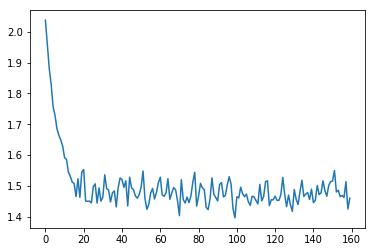

In [33]:
learning_rate = 0.001
rnn=LSTM(n_letters, n_hidden, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(rnn.parameters(), lr = learning_rate, momentum = 0.9)

n_iters = 8000
batch_size = 12
use_first_characters = 50
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for it in range(1, n_iters+1):
  
    optimizer.zero_grad()
    
    training_batch = torch.zeros(use_first_characters, batch_size, n_letters).cuda()
    category_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    batch = 0
    while batch < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomWeightedTrainingExample(use_first_characters)
        if len(abstract) < use_first_characters:
            # do this nasty "trick" to guarantee all the tensors have the same size
            continue
        
        training_batch[:, batch, :] = abstract_tensor[:, 0, :]
        category_batch[batch] = category_tensor[:]
        batch += 1
        
    output = rnn(training_batch)

    loss = criterion(output, category_batch)
    loss.backward()

    current_loss += loss.item()
    optimizer.step()
      
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)